# I. Preprocessing and Dataset
Now we want to predict all 58 labels for every face.

In [1]:
# -*- coding: utf-8 -*-
import cv2
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import skimage as sk
import skimage.io as skio
import scipy.spatial as sp
import torch
import random

# albumentations
%pip install albumentations --user --quiet

import albumentations as A

def seed_everything(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed_everything(42)

Note: you may need to restart the kernel to use updated packages.


In [2]:
# data/imm_face_db
# aaa.jpg + aaa.asf + bbb.jpg + bbb.asf...
filenames_without_extension = [filename.split('.')[0] for filename in os.listdir('imm_face_db') if filename.endswith('.jpg')]
set_of_images = set(filenames_without_extension)
# sort
set_of_images = sorted(set_of_images)
jpgs = [filename + '.jpg' for filename in set_of_images]
asfs = [filename + '.asf' for filename in set_of_images]
# read the images and asfs
images = [cv2.imread('imm_face_db/' + jpg) for jpg in jpgs]
asfs = [open('imm_face_db/' + asf).read() for asf in asfs]
def extract_point_data(asf_content):
    points_list = []
    for line in asf_content.splitlines():
        # Skip comments and empty lines
        if line.startswith("#") or not line.strip():
            continue
        # Split the line into components
        parts = line.split()
        if len(parts) == 1 and parts[0].endswith("jpg"):
            # take the name of the image
            image_name = parts[0]
        # print(parts)
        if len(parts) == 7 or len(parts) == 10:  # Check if the line has 7 parts (valid point line)
            # path_num = int(parts[0])
            point_num = int(parts[4])
            x_rel = float(parts[2])
            y_rel = float(parts[3])
            # Append the tuple (point#, x rel., y rel.) to the list
            points_list.append((point_num, x_rel, y_rel))
        
    return points_list, image_name

# extract the points from asfs
points = []
names = []
for asf in asfs:
    points_one_file, name = extract_point_data(asf)
    points.append(points_one_file)
    names.append(name)
assert len(points) == len(names)
# print(names)

# resize the images to the same size
min_h = min([image.shape[0] for image in images])
min_w = min([image.shape[1] for image in images])
images = [cv2.resize(image, (min_w, min_h)) for image in images] # list of images shape (n, h, w, c) where n is the number of images
# print(images[0].shape) # (h, w, c)
# all to gray scale
images = [cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in images] # (n, h, w)
# dict of images
# key is the name of the image xxx.jpg
# value1: the image
# value2: the points
images_dict = {}

for i in range(len(names)):
    # prop = 'neutral' if '1m' in names[i] or '1f' in names[i] else 'happy' if '2m' in names[i] or '2f' in names[i] else 'other'
    images_dict[names[i]] = (images[i], points[i])

In [3]:
# use all 6 images of the first 32 persons (index 1-32) as the training set (total 32 x 6 = 192 images) and the images of the remaining 8 persons (index 33-40) (8 * 6 = 48 images) as the validation set.

# just divide the image_dict into 2 parts
# find the name of file that is like xx-ym or xx-yf, and xx should be in the range of 1-32 for training set, 33-40 for validation set
training_images_dict = {}
validation_images_dict = {}
for key in images_dict.keys():
    num = int(key.split('-')[0])
    if 1 <= num <= 32:
        training_images_dict[key] = images_dict[key]
    elif 33 <= num <= 40:
        validation_images_dict[key] = images_dict[key]
    else:
        print('error')
print(len(training_images_dict), len(validation_images_dict))


192 48


In [4]:
# average all points in the nasal_points_indices
def get_all_points_and_new_dict(images_dict):
    points_dict = {}
    for key in images_dict.keys(): # key is the name of the image
        points = images_dict[key][1] # points of the image, shape (n, 3)
        # points be like [(point_num, x_rel, y_rel), ...]
        # we need only the x_rel and y_rel
        points = np.array([[point[1], point[2]] for point in points])
        image = images_dict[key][0]
        points_dict[key] = (image, points)
    return points_dict

training_points_dict = get_all_points_and_new_dict(training_images_dict)
validation_points_dict = get_all_points_and_new_dict(validation_images_dict)

Here comes the data augmentation part. We use affine transformation and color jittering to augment the dataset. Horizontal flip is not used because if a face is flipped, labels representing the left and right side of the face must be manually swapped, otherwise the model will only learn to predict the points into a middle line.

In [5]:
from torch.utils.data import Dataset, DataLoader
import torch
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [6]:
seed_everything(42)
# transform = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.RandomAffine(15, translate=(0.1, 0.1)), # rotate -15 to 15 degrees, translate 10% of the image size
#     transforms.RandomVerticalFlip(),
#     transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
#     transforms.ToTensor()
# ])
transform = A.Compose([
    A.Affine(rotate=(-15, 15), translate_percent={'x': 0.1, 'y': 0.1}),
    # A.HorizontalFlip(p=0.5), # FIXED: DO NOT FLIP THE IMAGE
    A.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    ToTensorV2(),
], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))
# FIXED: WE SHOULD NOT REMOVE THE INVISIBLE POINTS

class WholeFaceKeypointsDataset(Dataset):
    def __init__(self, points_dict, transform=None, normalize=True, resize=(240, 180)):
        self.points_dict = points_dict
        self.keys = list(points_dict.keys())
        self.transform = transform
        if resize:
            self.images = [cv2.resize(points_dict[key][0], resize) for key in self.keys]
        else:
            print('INFO: Not resizing the images')
            self.images = [points_dict[key][0] for key in self.keys]
        # torch-tensorify the images to (N, C, H, W)
        self.images = np.array(self.images)
        self.images = np.expand_dims(self.images, axis=1)
        self.images = torch.tensor(self.images, dtype=torch.float32)
        if normalize:
            self.images = self.images / 255.0
            self.images = (self.images - 0.5)
        self.points = [points_dict[key][1] for key in self.keys] # shape (n, 58, 2)
        # list[np.array(58, 2), ...] -> np.array(n, 58, 2)
        self.points = np.array(self.points)
        self.points = torch.tensor(self.points, dtype=torch.float32) # shape (n, 58, 2)
        assert self.images.shape[0] == self.points.shape[0]
        # assert points shape [1:] == (58, 2)
        assert self.images.shape[1:] == (1, 180, 240)
        assert self.points.shape[1:] == (58, 2)
        
    def __len__(self):
        return len(self.keys)
    
    def __getitem__(self, idx):
        seed_everything(idx)
        image = self.images[idx].numpy().transpose(1, 2, 0) # (1, 180, 240) -> (180, 240, 1)
        points_rel = self.points[idx].numpy() # (58, 2)
        assert image.shape == (180, 240, 1)
        assert points_rel.shape == (58, 2)
        points = points_rel.copy()
        # print("Points before transform", points.shape)
        points[:, 0] = points[:, 0] * image.shape[1] # x
        points[:, 1] = points[:, 1] * image.shape[0] # y
        if self.transform:
            transformed = self.transform(image=image, keypoints=points)
            image = transformed['image']
            points = transformed['keypoints']
            # print("Points after transform", points.shape)
            points = torch.tensor(points, dtype=torch.float32)
        else:
            image = torch.tensor(image, dtype=torch.float32)
            points = torch.tensor(points, dtype=torch.float32)
            image = image.permute(2, 0, 1) # (180, 240, 1) -> (1, 180, 240)
        # print(points.shape, image.shape)
        points_rel = points.numpy()
        points_rel[:, 0] = points_rel[:, 0] / image.shape[2] # x = x / w
        points_rel[:, 1] = points_rel[:, 1] / image.shape[1]
        points_rel = torch.tensor(points_rel, dtype=torch.float32)
        assert image.shape == (1, 180, 240)
        assert points.shape == (58, 2)
        return image, points
        
        
        
train_dataset = WholeFaceKeypointsDataset(training_points_dict, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataset = WholeFaceKeypointsDataset(validation_points_dict, transform=None)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

We visualize 6 random faces and their labels.

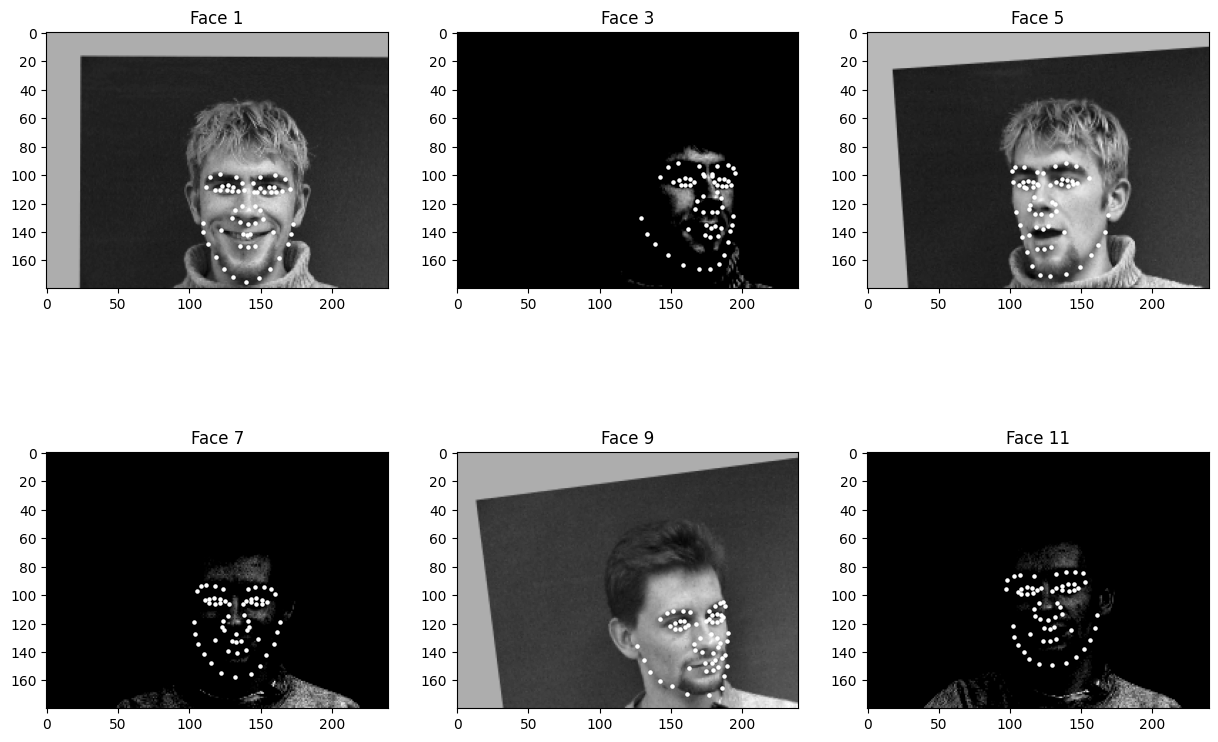

In [7]:
# 6 random faces and their labels
indices = [1, 3, 5, 7, 9, 11]
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()
for i, idx in enumerate(indices):
    # seed_everything(idx)
    image, points = train_dataset[idx]
    image = image.squeeze().numpy()
    # unnorm the image
    image = (image + 0.5) * 255.0
    # print(points)
    points = points.numpy()
    points[:, 0] = (points[:, 0]) * image.shape[1]
    points[:, 1] = (points[:, 1]) * image.shape[0]
    axes[i].imshow(image, cmap='gray')
    axes[i].scatter(points[:, 0], points[:, 1], c='w', s=5)
    axes[i].set_title(f'Face {idx}')
os.makedirs('2', exist_ok=True)
plt.savefig('2/sample_loader_faces.png')
plt.show()

# II. Model Architecture

Because we are detecting all facial keypoints, the model architecture will be a CNN with 6 convolutional layers. The model will output 58 keypoints, each with 2 coordinates (x, y).

In [8]:
from torch import nn

In [9]:
class ConvNet(nn.Module):
    def __init__(self, fc_hidden=2048, n_ptrs=58, dim_ptrs=2):
        super(ConvNet, self).__init__()
        self.fc_hidden = fc_hidden
        self.n_ptrs = n_ptrs
        self.dim_ptrs = dim_ptrs
        self.layers = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), # (N, 32, 180, 240)
            nn.ReLU(),
            nn.MaxPool2d(2), # (N, 32, 90, 120) # optional
            nn.Conv2d(32, 64, 3, padding=1), # (N, 64, 90, 120)
            nn.ReLU(),
            nn.MaxPool2d(2), # (N, 64, 45, 60) # optional
            nn.Conv2d(64, 128, 3, padding=1), # (N, 128, 45, 60)
            nn.ReLU(),
            nn.MaxPool2d(2), # (N, 128, 22, 30) # optional
            nn.Conv2d(128, 256, 3, padding=1), # (N, 256, 22, 30)
            nn.ReLU(),
            nn.MaxPool2d(2), # (N, 256, 11, 15) # optional
            nn.Conv2d(256, 512, 3, padding=1), # (N, 512, 11, 15)
            nn.ReLU(),
            nn.MaxPool2d(2), # (N, 512, 5, 7) # optional
            nn.Conv2d(512, 512, 3, padding=1), # (N, 512, 5, 7)
            nn.ReLU(),
            nn.MaxPool2d(2), # (N, 512, 2, 3) # optional
            # fc below
            nn.Flatten(), # (N, 256*5*7)
            nn.Linear(512*2*3, self.fc_hidden), # (N, 1024)
            nn.ReLU(),
            nn.Linear(self.fc_hidden, n_ptrs*dim_ptrs) # (N, 58*2)
        )
        
    def forward(self, x):
        x = self.layers(x)
        # print(x.shape)
        x = x.view(-1, self.n_ptrs, self.dim_ptrs)
        return x
    

# III. Training

In [10]:
from tqdm import tqdm

100%|██████████| 300/300 [02:27<00:00,  2.04it/s, Epoch 300/300, Train Loss: 0.0003710477370380734, Val Loss: 0.001192137894880337]  


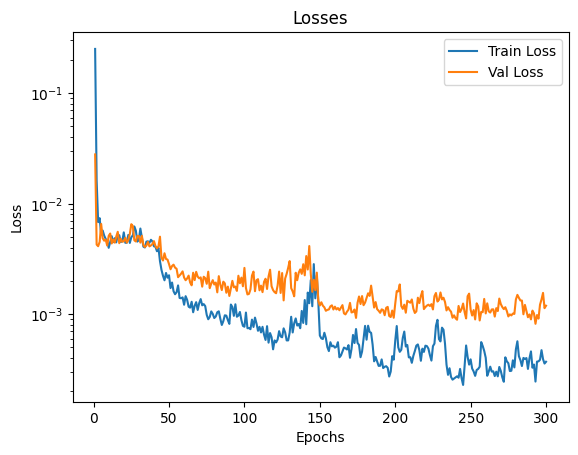

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ConvNet().to(device)
# seed_everything(42)

# def init_weights(m):
#     if type(m) == nn.Conv2d or type(m) == nn.Linear:
#         nn.init.xavier_normal_(m.weight)
#         nn.init.zeros_(m.bias)
# model.apply(init_weights)

LR = 1e-3
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
epochs = 300
loop = tqdm(range(epochs))
seed_everything(42)
def train_and_give_list(train_loader, model, criterion, optimizer, epochs):
    train_losses = []
    val_losses = []
    for epoch in loop:
        model.train()
        train_loss = 0.0
        for i, (images, points) in enumerate(train_loader):
            images, points = images.to(device), points.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, points)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, points in val_loader:
                images, points = images.to(device), points.to(device)
                outputs = model(images)
                loss = criterion(outputs, points)
                val_loss += loss.item()
            val_loss /= len(val_loader)
            val_losses.append(val_loss)
        # print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}')
        loop.set_postfix_str(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}')
    return train_losses, val_losses

train_losses, val_losses = train_and_give_list(train_loader, model, criterion, optimizer, epochs)

# plot the losses
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# log scale
plt.yscale('log')
plt.title('Losses')
plt.legend()
import os
os.makedirs('2', exist_ok=True)
plt.savefig('2/losses.png', dpi=300, bbox_inches='tight')
plt.show()

We show 2 correct detections and 2 incorrect detections.

Corrects: [6, 8, 10, 11, 20]


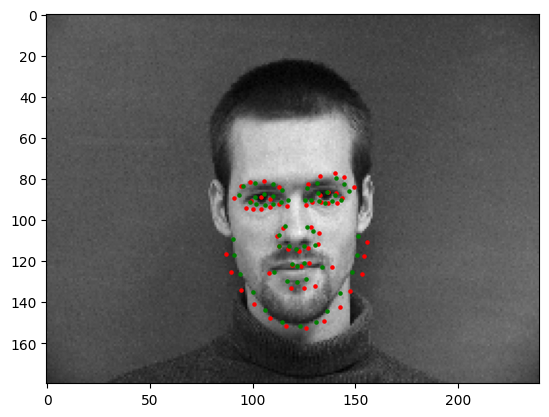

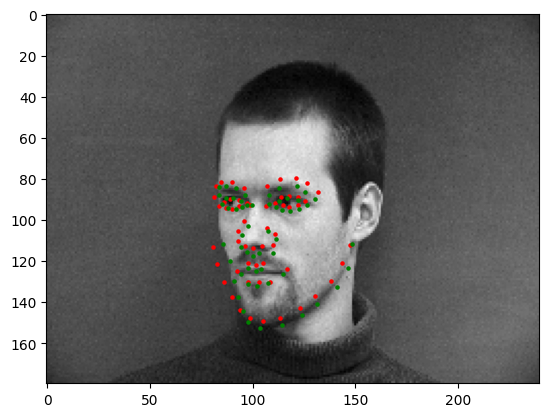

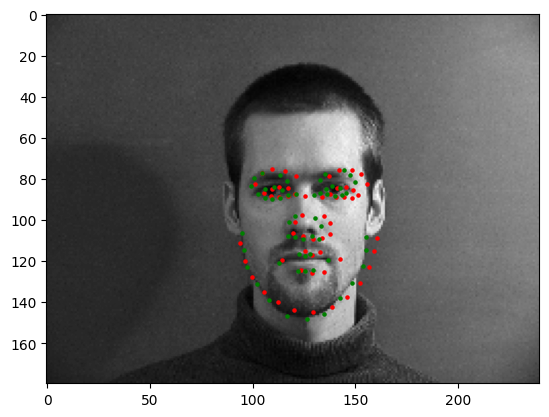

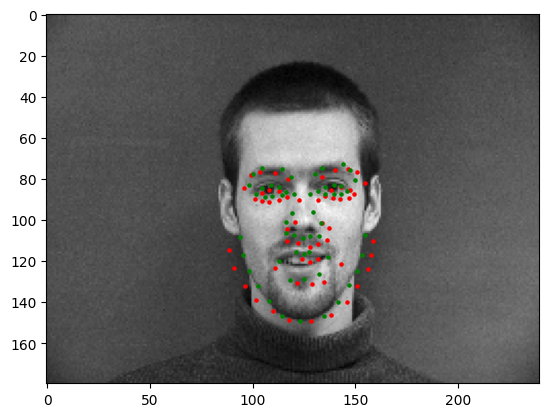

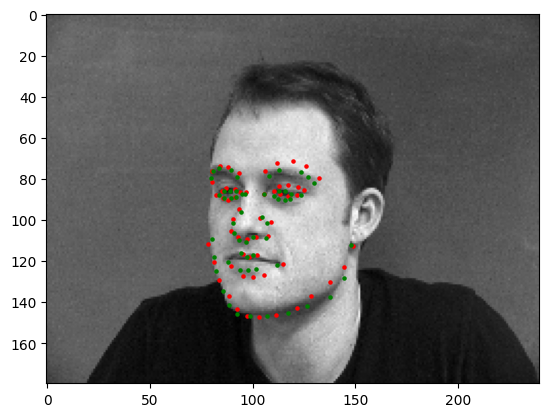

In [12]:
def find_corrects(model, dataset, img_indices, correct=True):
    model.eval()
    # print(img_indices)
    corrects = []
    with torch.no_grad():
        for i in img_indices:
            # seed_everything(i)
            image, points_annotation = dataset[int(i)]
            image = image.unsqueeze(0).to(device)
            output = model(image.float())
            loss = criterion(output, points_annotation.unsqueeze(0).to(device))
            # print(f'Loss: {loss}')
            if loss < 0.00025:
                # print('Correct at', i)
                corrects.append(i)
    return corrects
            


img_indices = range(len(val_dataset))
cor = find_corrects(model, val_dataset, img_indices, correct=True)
print('Corrects:', cor)


def plot_faces_with_points(model, dataset, img_indices, correct):
    model.eval()
    with torch.no_grad():
        for i in img_indices:
            # seed_everything(i)model
            image, points_annotation = dataset[int(i)]
            image = image.unsqueeze(0).to(device)
            output = model(image.float())
            loss = criterion(output, points_annotation.unsqueeze(0).to(device))
            # print(f'Loss: {loss}')
            output = output.squeeze().cpu().numpy()
            image = image.squeeze().cpu().numpy()
            image = (image + 0.5) * 255
            image = image.astype(np.uint8)
            h, w = image.shape
            points_annotation = points_annotation.numpy()
            points_annotation[:, 0] = points_annotation[:, 0] * w
            points_annotation[:, 1] = points_annotation[:, 1] * h
            points = output.copy()
            points[:, 0] = points[:, 0] * w
            points[:, 1] = points[:, 1] * h
            plt.imshow(image, cmap='gray')
            plt.scatter(points[:, 0], points[:, 1], c='r', s=5)
            plt.scatter(points_annotation[:, 0], points_annotation[:, 1], c='g', s=5)
            a = 'correct' if correct else 'wrong'
            plt.savefig(f'2/{a}_{i}.png', dpi=300, bbox_inches='tight')
            plt.show()
            
# pass in cor
plot_faces_with_points(model, val_dataset, cor, correct=True)

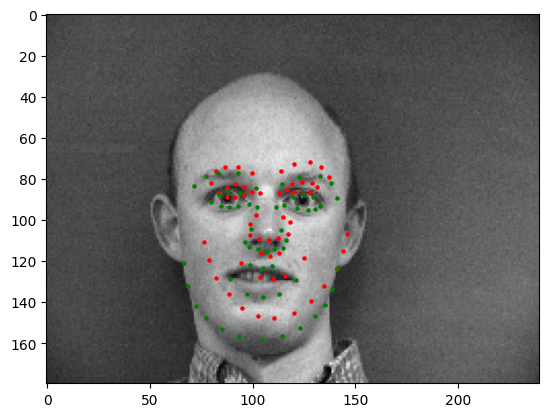

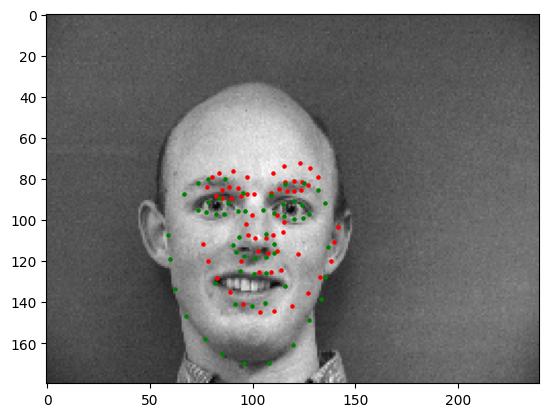

In [13]:
# failed things
failed = list(set(img_indices) - set(cor))[:2]
plot_faces_with_points(model, val_dataset, failed, correct=False)

# IV. Visualizing Learned Filters

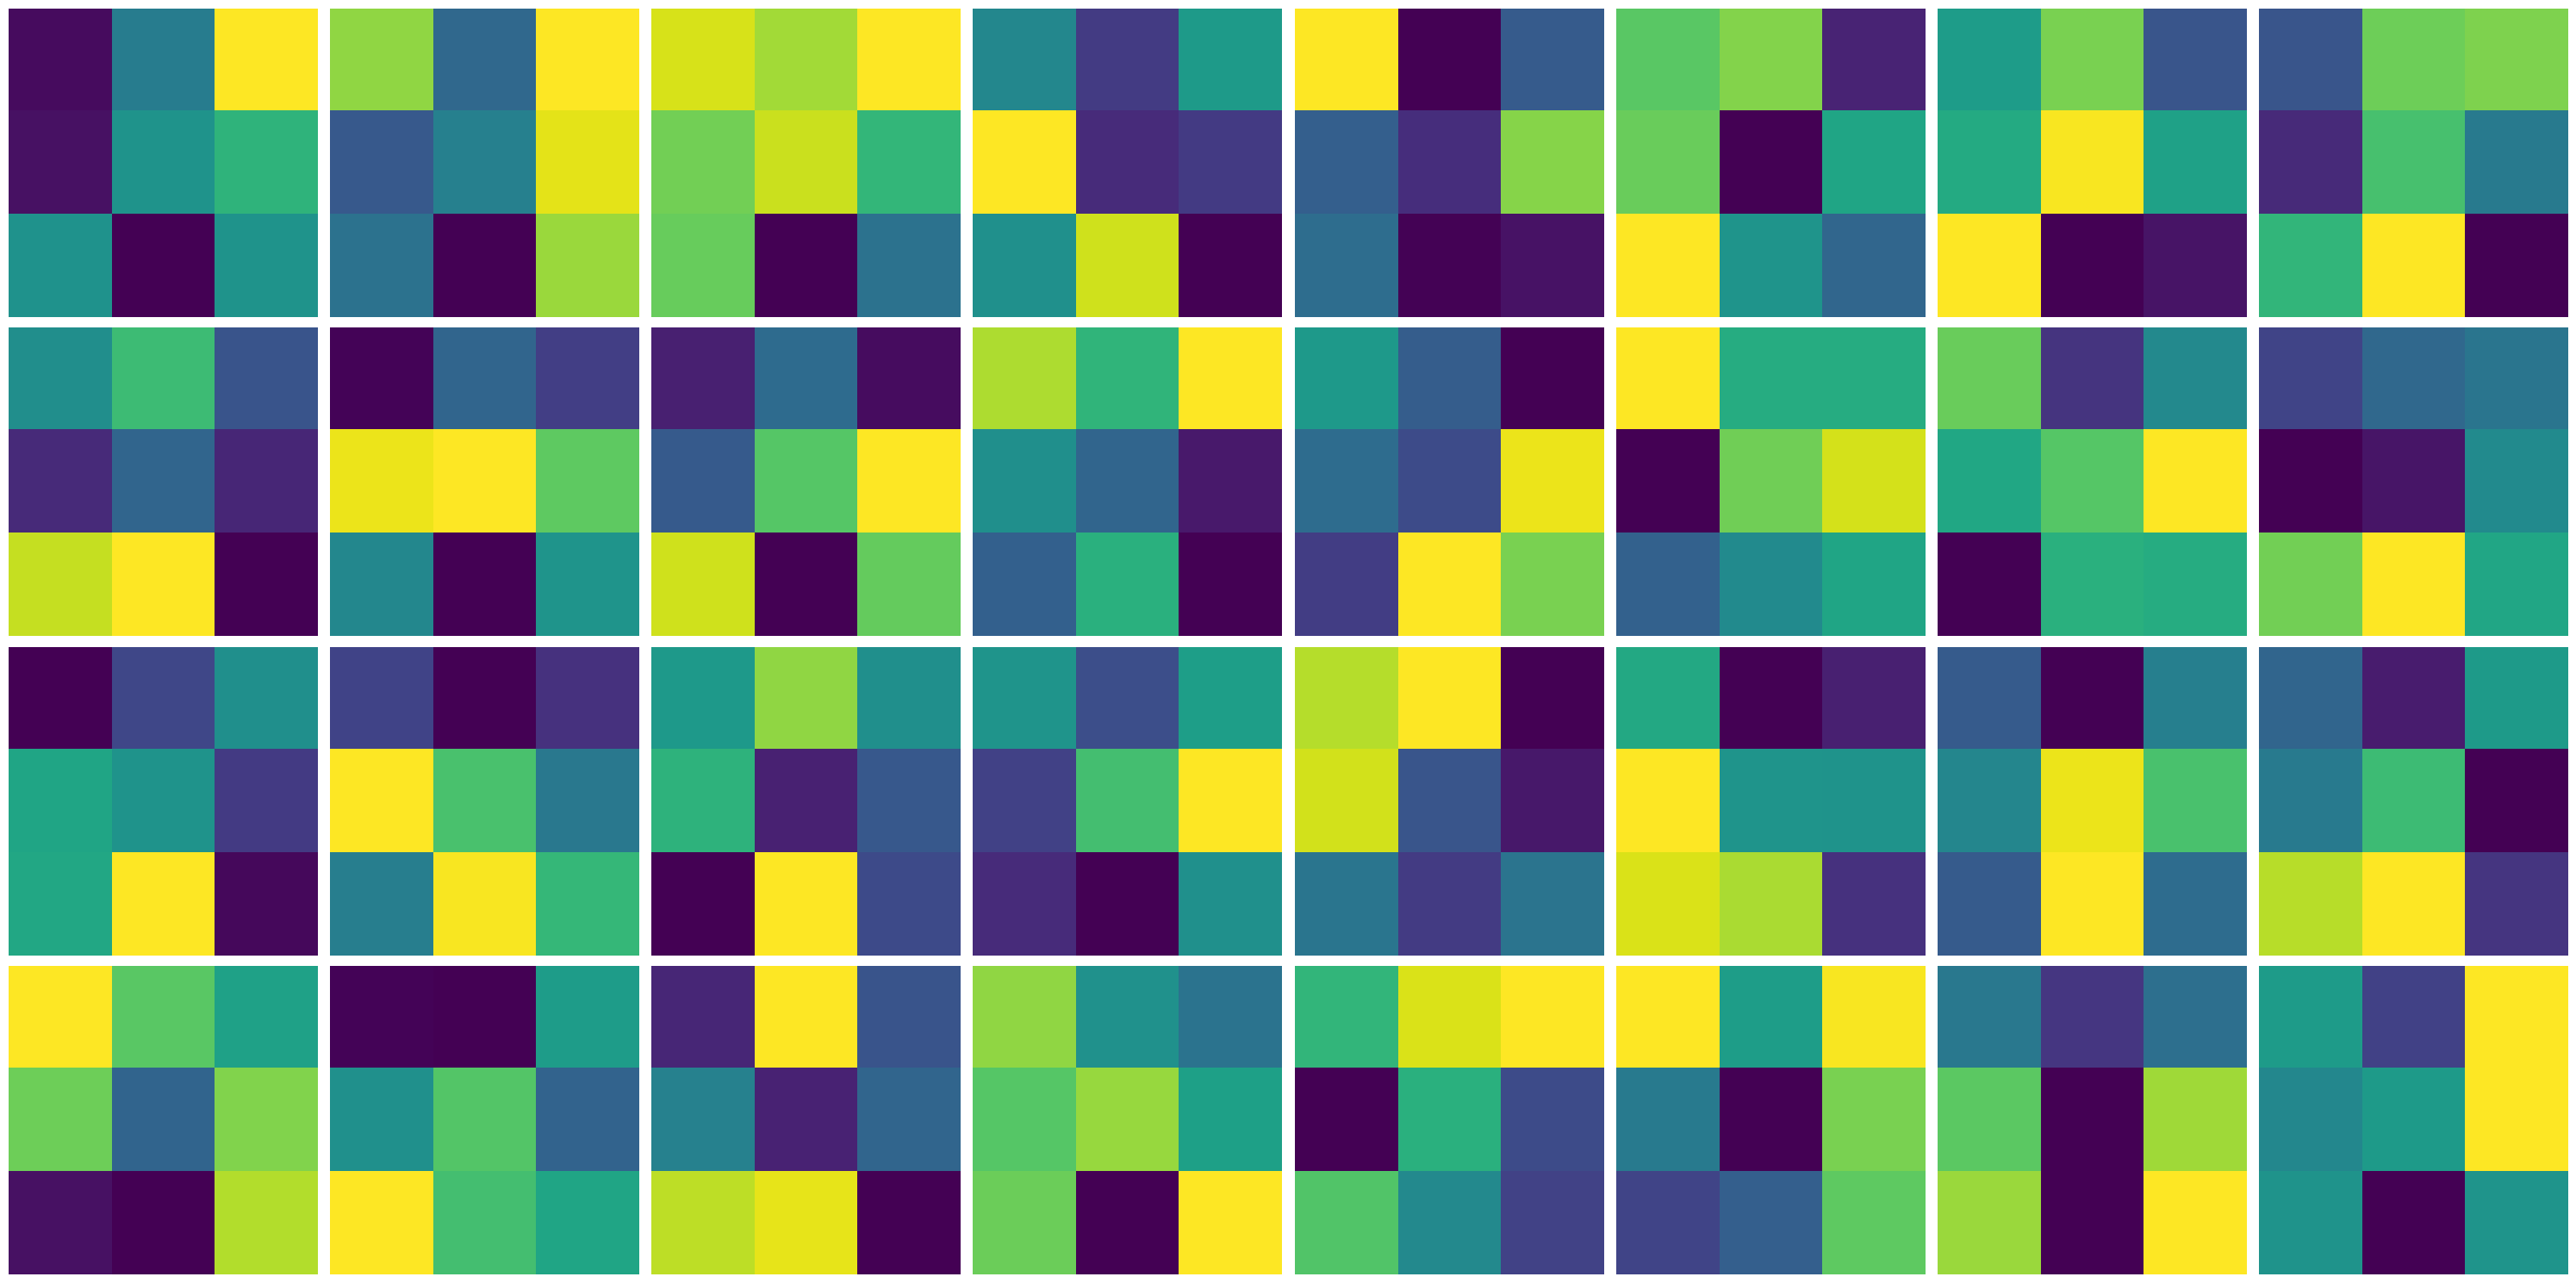

In [14]:
# visualize the filters
def plot_filters(model):
    model.eval()
    filters = model.layers[0].weight.data.cpu().numpy()
    fig, axes = plt.subplots(4, 8, figsize=(30, 15))
    axes = axes.ravel()
    for i in range(32):
        axes[i].imshow(filters[i][0])
        axes[i].axis('off')
    plt.tight_layout()
    plt.savefig('2/filters_0.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # # layer 1
    # filters = model.layers[3].weight.data.cpu().numpy()
    # fig, axes = plt.subplots(8, 8, figsize=(30, 30))
    # axes = axes.ravel()
    # for i in range(64):
    #     axes[i].imshow(filters[i][0], cmap='gray')
    #     axes[i].axis('off')
    # plt.tight_layout()
    # plt.savefig('2/filters_1.png', dpi=300, bbox_inches='tight')
    # plt.show()
    
    # # layer 2
    # filters = model.layers[6].weight.data.cpu().numpy()
    # fig, axes = plt.subplots(8, 16, figsize=(30, 15))
    # axes = axes.ravel()
    # for i in range(128):
    #     axes[i].imshow(filters[i][0], cmap='gray')
    #     axes[i].axis('off')
    # plt.tight_layout()
    # plt.savefig('2/filters_2.png', dpi=300, bbox_inches='tight')
    # plt.show()
    
    # # layer 3
    # filters = model.layers[9].weight.data.cpu().numpy()
    # fig, axes = plt.subplots(16, 16, figsize=(30, 30))
    # axes = axes.ravel()
    # for i in range(256):
    #     axes[i].imshow(filters[i][0], cmap='gray')
    #     axes[i].axis('off')
    # plt.tight_layout()
    # plt.savefig('2/filters_3.png', dpi=300, bbox_inches='tight')
    # plt.show()
    
    # # layer 4
    # filters = model.layers[12].weight.data.cpu().numpy()
    # fig, axes = plt.subplots(16, 32, figsize=(30, 15))
    # axes = axes.ravel()
    # for i in range(512):
    #     axes[i].imshow(filters[i][0], cmap='gray')
    #     axes[i].axis('off')
    # plt.tight_layout()
    # plt.savefig('2/filters_4.png', dpi=300, bbox_inches='tight')
    # plt.show()
    
    # # layer 5
    # filters = model.layers[15].weight.data.cpu().numpy()
    # fig, axes = plt.subplots(16, 32, figsize=(30, 15))
    # axes = axes.ravel()
    # for i in range(512):
    #     axes[i].imshow(filters[i][0], cmap='gray')
    #     axes[i].axis('off')
    # plt.tight_layout()
    # plt.savefig('2/filters_5.png', dpi=300, bbox_inches='tight')
    # plt.show()
    
plot_filters(model)